In [1]:
# Gym 
import gym
from gym import wrappers
from gym.spaces.utils import flatdim

import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange

import io
import base64
from IPython.display import HTML

# Comment out for debugging
import warnings
warnings.filterwarnings('ignore')

In [2]:
def play_video(ep_number: int):
    video = io.open(f"./gym-results/rl-video-episode-{ep_number}.mp4", 'r+b').read()
    encoded = base64.b64encode(video)
    return HTML(data='''
        <video width="360" height="auto" alt="test" controls><source src="data:video/mp4;base64,{0}" type="video/mp4" /></video>'''
    .format(encoded.decode('ascii')))

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='valid')
    return y_smooth

100%|██████████| 50000/50000 [00:01<00:00, 29018.41it/s]


Text(0.5, 1.0, 'Rewards over 1588 episodes')

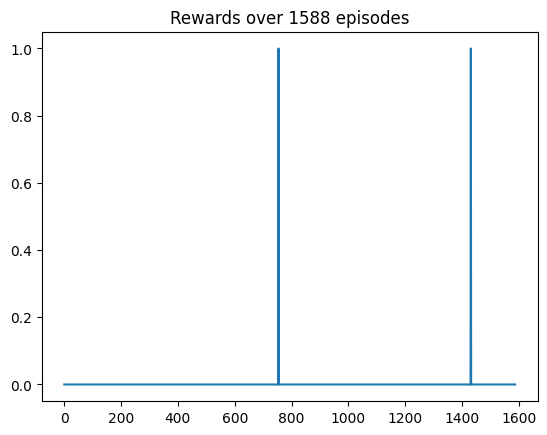

In [17]:
# Frozen Lake Environment
env = gym.make("FrozenLake-v1", map_name="8x8", is_slippery=False)
env = wrappers.RecordVideo(env, "./gym-results")
env.reset()

# hyperparams
num_steps = 50000
random_rewards = [0]
random_lengths = [0]
ep_len = 0
for _ in trange(num_steps):
   action = env.action_space.sample() 
   observation, reward, done, info = env.step(action)

   if done:
      random_rewards.append(reward)
      random_lengths.append(ep_len)
      observation = env.reset()
      ep_len = 0
   
   ep_len += 1
env.close()

plt.plot(random_rewards)
plt.title(f"Rewards over {len(random_rewards)} episodes")

Cumulative R: 829.0: 100%|██████████| 50000/50000 [01:10<00:00, 707.61it/s]


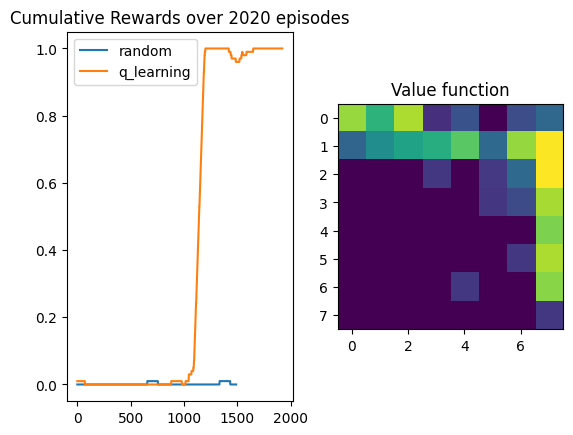

In [22]:
env = gym.make("FrozenLake-v1", map_name="8x8", is_slippery=False)
env = wrappers.RecordVideo(env, "./frozen_lake")
obs = env.reset()

# hyperparams
num_steps = 50000
lr = 0.5
gamma = 0.99
epsilon = 0.01

# Q table
nS = flatdim(env.observation_space)
nA = flatdim(env.action_space)
q_table = np.zeros((nS, nA))

def policy(o, epsilon, q_table):
   if np.random.rand() < epsilon:
      return env.action_space.sample()

   return np.random.choice(np.where(q_table == q_table.max())[0])

q_rewards = [0]
q_lengths = [0]
p_bar = trange(num_steps)

ep_len = 0
for step in p_bar:
   action = policy(obs, epsilon, q_table[obs])
   next_obs, reward, done, info = env.step(action)

   # Current table should be consistent 1 step into the future
   bellman_error = (reward + gamma * (1-done) *  np.max(q_table[next_obs])) - q_table[obs, action]
   q_table[obs, action] += lr * bellman_error

   if done:
      q_rewards.append(reward)
      q_lengths.append(ep_len)
      q_table[next_obs] = 0
      obs = env.reset()
      ep_len = 0

   p_bar.set_description(f"Cumulative R: {np.cumsum(q_rewards)[-1]}")
   obs = next_obs
   ep_len += 1
env.close()

plt.subplot(1,2,1)
plt.plot(smooth(random_rewards, 100), label="random")
plt.plot(smooth(q_rewards, 100), label="q_learning")
plt.title(f"Cumulative Rewards over {len(q_rewards)} episodes")
plt.legend()

plt.subplot(1,2,2)
plt.imshow(np.mean(q_table, axis=1).reshape(int(np.sqrt(nS)), int(np.sqrt(nS))))
plt.title("Value function")
plt.savefig("./frozen_lake/plots")